#### 1. Import Libraries
The first cell imports libraries. This code uses Tensorflow version 0.9. If Tensorflow version is not the same, the code may not work as expected.
Make sure Tensorflow environment is on before starting this notebook.

```
> source activate tensorflow
```

Some libraries need to be install after Tensorflow enviroment starts.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import os
import random
import time
from six.moves import cPickle

import numpy as np
import tensorflow as tf

from tensorflow.models.rnn.ptb import reader

%matplotlib inline
from matplotlib import pylab
from sklearn.manifold import TSNE

#### 2. Input data processing functions
The next part is function definitions to read and prepare data for learning.

In [2]:
def _read_words(filename):
    "Given a filename, returns a list of words, which are separated by a space."
    with tf.gfile.GFile(filename, "r") as f:
        return f.read().decode("utf-8").replace("\n", " ").split()

def _build_vocab(data):
    "Given data (a list of words), returns a sorted words list and dictionary of word/frequency pairs."
    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

def _file_to_word_ids(data, word_to_id):
    
    return [word_to_id[word] for word in data if word in word_to_id]

#### 3. Configurations
Config class defines configuration parameters.

In [9]:
class Config():
    learning_rate = 1.0    # the initial value of a learning rate
    max_grad_norm = 5      # the maximum permissible norm of the gradient
    num_layers = 2         # the number of LSTM layers
    num_steps = 20         # the number of unrolled steps of LSTM
    hidden_size = 200      # the number of LSTM units
    max_epoch = 5          # the number of epochs with the initial learning rate
    max_max_epoch = 15     # the total number of epochs
    #max_max_epoch = 1    # for debugging
    keep_prob = 1.0        # the probability of keeping weights in dropout layer
    lr_decay = 0.5         # the learning rate defay factor
    batch_size = 20        # the batch size
    vocab_size = 100000    # vocabulary size

#### 4. Utility funcions
These two functions are utilities to fix a variable scope problem on tensorflow. These are small hack to reuser model and variables in sampling.

In [10]:
def get_scope_variable(scope_name, var, shape=None):
    with tf.variable_scope(scope_name) as scope:
        try:
            v = tf.get_variable(var, shape)
        except ValueError:
            scope.reuse_variables()
            v = tf.get_variable(var)
    return v

def cell_with_retry(cell, inputs, time_step, state):
    try:
        (cell_output, state) = cell(inputs[:, time_step, :], state)
    except ValueError:
        tf.get_variable_scope().reuse_variables()
        (cell_output, state) = cell(inputs[:, time_step, :], state)
    return (cell_output, state)

#### 5. Model definition
This is a model definition. The model uses LSTM (long short term memory) cell, which is stacked up by config.num_layers.

In [11]:
class Model():
    def __init__(self, is_training, config):
        self.batch_size = batch_size = config.batch_size
        self.num_steps = num_steps = config.num_steps
        size = config.hidden_size
        vocab_size = config.vocab_size
        
        self._input_data = tf.placeholder(tf.int32, [batch_size, num_steps])
        self._targets = tf.placeholder(tf.int32, [batch_size, num_steps])

        # gets LSTM cell
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(size, forget_bias=0.0)
        # dropout setting, increase/decrease number of neurons
        if is_training and config.keep_prob < 1:
            lstm_cell = tf.nn.rnn_cell.DropoutWrapper(
                lstm_cell, output_keep_prob=config.keep_prob)
        # stacks up cells
        self._cell = cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.num_layers)

        self._initial_state = cell.zero_state(batch_size, tf.float32)
        
        outputs = []
        state = self._initial_state
        
        # softmax of weights
        softmax_w = get_scope_variable("RNN", "softmax_w", [size, vocab_size])
        # softmax of bias
        softmax_b = get_scope_variable("RNN", "softmax_b", [vocab_size])
        
        # looks up embeddings and gets input
        with tf.device("/cpu:0"):
            embedding = get_scope_variable("RNN", "embedding", [vocab_size, size])
            inputs = tf.nn.embedding_lookup(embedding, self._input_data)

        with tf.variable_scope("RNN"):
            for time_step in range(num_steps):
                if time_step > 0: tf.get_variable_scope().reuse_variables()
                # updates a state and computes outputs
                (cell_output, state) = cell_with_retry(cell, inputs, time_step, state)
                outputs.append(cell_output)
            

        # calculates dropouts.
        if is_training and config.keep_prob < 1:
            # the second argument is probablitiy, keep_prob.
            # outputs will be scaled by 1/keep_prob.
            inputs = tf.nn.dropout(inputs, config.keep_prob)

        output = tf.reshape(tf.concat(1, outputs), [-1, size])
        
        # caclulates y = Wx + b (score y is called logits)
        logits = tf.matmul(output, softmax_w) + softmax_b
        # computes softmax cross entropy loss of batch_size
        loss = tf.nn.seq2seq.sequence_loss_by_example(
            [logits],
            [tf.reshape(self._targets, [-1])],
            [tf.ones([batch_size * num_steps])])
        # gets scalar value of normalized loss
        self._cost = cost = tf.reduce_sum(loss) / batch_size
        self._final_state = state
        self._probs = tf.nn.softmax(logits)
        
        if not is_training:
            return

        self._lr = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),
                                          config.max_grad_norm)
        # optimazation
        optimizer = tf.train.GradientDescentOptimizer(self.lr)
        self._train_op = optimizer.apply_gradients(zip(grads, tvars))
        
        # updates embeddings. computes similarity based on cosine distance
        norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
        self._normalized_embeddings = embedding / norm
        
        # saves cost in a sumarry for visualization
        tf.scalar_summary("cost", cost)

    def assign_lr(self, session, lr_value):
        session.run(tf.assign(self.lr, lr_value))

    @property
    def input_data(self):
        return self._input_data

    @property
    def targets(self):
        return self._targets

    @property
    def initial_state(self):
        return self._initial_state

    @property
    def cost(self):
        return self._cost

    @property
    def cell(self):
        return self._cell
    
    @property
    def final_state(self):
        return self._final_state
    
    @property
    def probs(self):
        return self._probs

    @property
    def lr(self):
        return self._lr

    @property
    def train_op(self):
        return self._train_op
    
    # sampling function to generate a sequence of words
    def sample(self, session, words, vocab, num=200, prime=' ', sampling_type=1):
        state = session.run(self.cell.zero_state(1, tf.float32))
        if not len(prime) or prime == " ":
            prime  = random.choice(list(vocab.keys()))    
        print (prime)
        for word in prime.split()[:-1]:
            print (word)
            x = np.zeros((1, 1))
            x[0, 0] = vocab.get(word,0)
            feed = {self.input_data: x, self.initial_state:state}
            [state] = session.run([self.final_state], feed)
         
        def weighted_pick(weights):
            t = np.cumsum(weights)
            s = np.sum(weights)
            return(int(np.searchsorted(t, np.random.rand(1)*s)))

        ret = prime
        word = prime.split()[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab.get(word,0)
            feed = {self.input_data: x, self.initial_state:state}
            [probs, state] = session.run([self.probs, self.final_state], feed)
            p = probs[0]

            if sampling_type == 0:
                sample = np.argmax(p)
            else: # sampling_type == 1 default:
                sample = weighted_pick(p)

            pred = words[sample]
            ret += ' ' + pred
            word = pred
        return ret

#### 6. Preprocessing
Preparing input data, configuration and some more of utilities.

In [12]:
data_dir = "data"
train_path = os.path.join(data_dir, "input.txt")
save_dir = "saved"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

data = _read_words(train_path)
words, word_to_id = _build_vocab(data)
train_data = _file_to_word_ids(data, word_to_id)
vocabulary = len(word_to_id)

config = Config()
config.vocab_size = vocabulary

current_milli_time = lambda: int(round(time.time() * 1000))

#### 7. Epoch function
Function definitions to loop over input data and epoch (iteration of complete dataset) process.

In [13]:
def _iterator(raw_data, batch_size, num_steps):
    raw_data = np.array(raw_data, dtype=np.int32)
    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]

    epoch_size = (batch_len - 1) // num_steps
    if epoch_size == 0:
        raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

    for i in range(epoch_size):
        x = data[:, i*num_steps:(i+1)*num_steps]
        y = data[:, i*num_steps+1:(i+1)*num_steps+1]
        yield (x, y)

def run_epoch(session, m, data, eval_op, verbose=False):
    epoch_size = ((len(data) // m.batch_size) - 1) // m.num_steps
    start_time = time.time()
    costs = 0.0
    iters = 0
    state = m.initial_state.eval()
    # creates SummaryWriter
    timestamp = str(current_milli_time())
    if not os.path.exists(os.path.join(save_dir, "summaries", timestamp)):
        os.makedirs(os.path.join(save_dir, "summaries", timestamp))
    train_summary_writer = tf.train.SummaryWriter(
        os.path.join(save_dir, "summaries", timestamp), session.graph)
    summary_op = tf.merge_all_summaries()
    
    for step, (x, y) in enumerate(_iterator(data,
                                            m.batch_size,
                                            m.num_steps)):
        cost, state, _, summary = session.run([m.cost, m.final_state, eval_op, summary_op],
                                              {m.input_data: x,
                                               m.targets: y,
                                               m.initial_state: state})
        train_summary_writer.add_summary(summary, step)
        
        costs += cost
        iters += m.num_steps

        if verbose and step % (epoch_size // 10) == 10:
            print("%.3f perplexity: %.3f speed: %.0f wps" %
                  (step * 1.0 / epoch_size, np.exp(costs / iters),
                   iters * m.batch_size / (time.time() - start_time)))

    return np.exp(costs / iters)

#### 8. Training
The RNN starts running in this part. It will take log to finish the defined number of epoch.
When it completes, the training results will be saved in a file.

During the training, performace measurements will be displayed in the style of:

```
0.017 perplexity: 36138.733 speed: 525 wps
```

The first value shows how much data have been processed so far. The second value is the perplexity. The third value is a processing speed. 


In [14]:
with open(os.path.join(save_dir, 'words_vocab.pkl'), 'wb') as f:
    cPickle.dump((words, word_to_id), f)

perfs = []
with tf.Graph().as_default(), tf.Session() as session:
    
    model = Model(is_training=True, config=config)
    
    tf.initialize_all_variables().run()
    saver = tf.train.Saver()
    
    for i in range(config.max_max_epoch):
        # learning rate decay
        lr_decay = config.lr_decay ** max(i - config.max_epoch, 0.0)
        model.assign_lr(session, config.learning_rate * lr_decay)

        print("Epoch: %d Learning rate: %.3f" % (i + 1, session.run(model.lr)))
        train_perplexity = run_epoch(session,
                                     model,
                                     train_data,
                                     model.train_op,
                                     verbose=True)
        print("Epoch: %d Train Perplexity: %.3f" % (i + 1, train_perplexity))
        perfs.append(train_perplexity)
    
    final_embeddings = model._normalized_embeddings.eval(session=session)
    
    checkpoint_path = os.path.join(save_dir, 'model.ckpt')
    saver.save(session, checkpoint_path)
    print("model saved to {}".format(checkpoint_path))

Epoch: 1 Learning rate: 1.000
0.017 perplexity: 56016.433 speed: 514 wps
0.117 perplexity: 4405.311 speed: 898 wps
0.217 perplexity: 2941.609 speed: 965 wps
0.317 perplexity: 2398.627 speed: 984 wps
0.417 perplexity: 2073.629 speed: 993 wps
0.517 perplexity: 1818.792 speed: 1000 wps
0.617 perplexity: 1614.475 speed: 1001 wps
0.717 perplexity: 1458.274 speed: 1004 wps
0.817 perplexity: 1332.218 speed: 1008 wps
0.917 perplexity: 1235.743 speed: 1013 wps
Epoch: 1 Train Perplexity: 1168.729
Epoch: 2 Learning rate: 1.000
0.017 perplexity: 590.027 speed: 505 wps
0.117 perplexity: 559.346 speed: 907 wps
0.217 perplexity: 551.158 speed: 959 wps
0.317 perplexity: 537.801 speed: 983 wps
0.417 perplexity: 521.002 speed: 998 wps
0.517 perplexity: 499.158 speed: 1002 wps
0.617 perplexity: 480.753 speed: 1008 wps
0.717 perplexity: 466.261 speed: 1010 wps
0.817 perplexity: 450.404 speed: 1014 wps
0.917 perplexity: 439.196 speed: 1014 wps
Epoch: 2 Train Perplexity: 431.122
Epoch: 3 Learning rate: 1.00

#### 9. Plotting perplexity
The perplexity is a main perfomance measurement and descibes a training progress. The numbers are shown above, but the visualization is better to grasp the overall tendency.

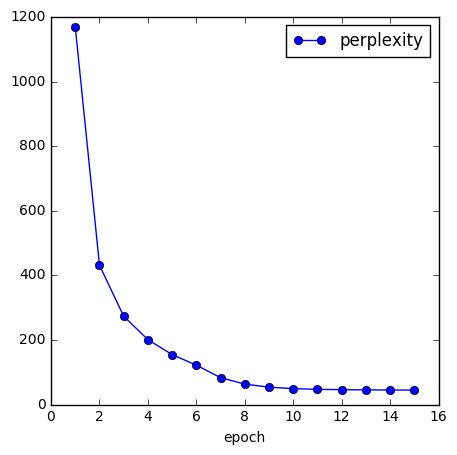

In [15]:
fig, ax = pylab.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.plot(np.arange(1, 16), perfs, '-o', label="perplexity")
pylab.xlabel('epoch')
pylab.legend(loc='best')
pylab.show()

#### 10. Word2vec
This is a functions to plot word2vec. The result shows similarity of words. An abosolute position in 2-D plane changes if the function runs again, however, relative distances between words are consistent.

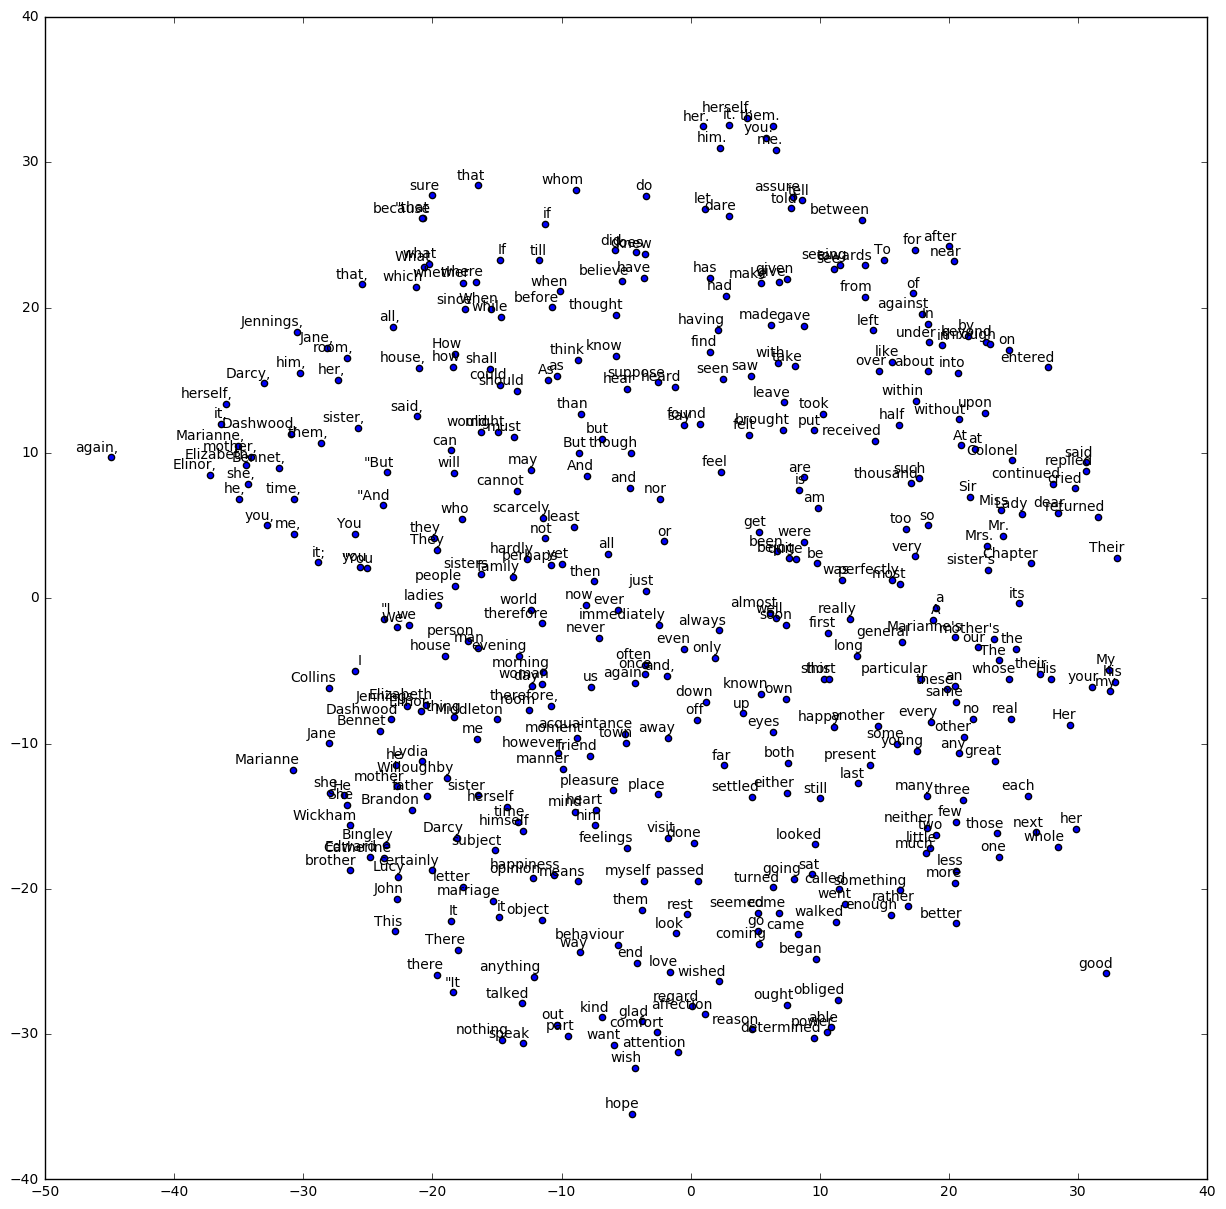

In [20]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2),
                       textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

def draw(embeddings, reverse_dictionary):
    num_points = 400
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
    words = [reverse_dictionary[i] for i in range(1, num_points+1)]
    plot(two_d_embeddings, words)

reverse_dictionary = dict(zip(word_to_id.values(), word_to_id.keys())) 
draw(final_embeddings, reverse_dictionary)


#### 11. Sequence of words
The function below generates sequence of words. We can try this part many times. When the sampling type is 1(weight pick), the result varies.

In [19]:
# num: the number of words to generate
# prime: the seed word(s)
# sampling_type: sampling type, 0: argmax, 1: weight pick
def sample(num, prime, sampling_type):
    with open(os.path.join(save_dir, 'words_vocab.pkl'), 'rb') as f:
        words, vocab = cPickle.load(f)
    config.batch_size=1
    config.num_steps =1
    model = Model(is_training=False, config=config)
    with tf.Session() as session:
        tf.initialize_all_variables().run()
        saver = tf.train.Saver(tf.all_variables())
        ckpt = tf.train.get_checkpoint_state(save_dir)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(session, ckpt.model_checkpoint_path)
            print(model.sample(session, words, vocab, num, prime, sampling_type))
            
sample(200, "Elizabeth", 1)

Elizabeth
Elizabeth saw him called exceedingly earnestly on: "I never had Mrs. indignation. "I am unwillingly said self-command, pretty, we are all going down liable to liked him?" "Do not you know to be cross acquainted with you. And it is the mistake so south-westerly unconnected with Colonel Brandon's father. "But, make her WE suppose she silence as she need ever give them compliments to herself else; but, may be of last expressed; and led away each lady, merely ran "Mrs. soon. Mrs. Jennings told him that she had no extraordinary intelligence whatever could put her another increase of diminished it so small for as she was rationally and if ever by her marriage, his eagerness him would have ceased to take her a numerous at all; and by her walk to look her for having there entirely to alternative, liked otherwise after nerves." As they see But they well joined by the two attention, and their censure of Rosings was particularly hope to be satisfied, she had thought of his possession in